In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys

In [3]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
    
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


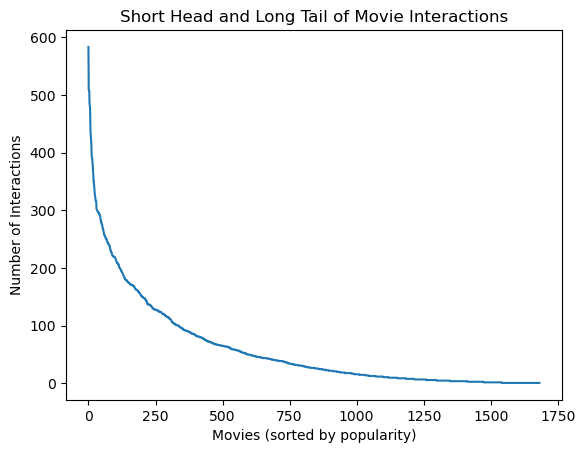

In [4]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


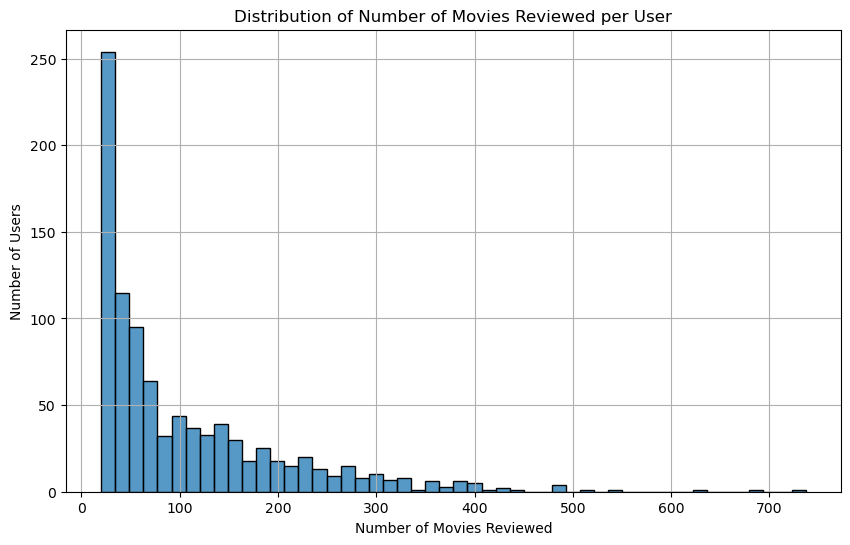

Number of users: 943


In [5]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [6]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9370


## SVD++ Model

In [7]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # Map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, true_r) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision_avg = np.mean(list(precisions.values()))
    recall_avg = np.mean(list(recalls.values()))

    return precision_avg, recall_avg

In [8]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [9]:
def calculate_gini_of_recommendations(recommendation_counts):
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_counts.values()))

    # Calculate the Gini index
    gini_index = gini(recommendation_array)
    return gini_index

In [10]:
def arp_(users, recs, popularity):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        popularity_sum = 0
        for item in rec:
            p = popularity[int(item)]
            popularity_sum += p
        popularity_sum = popularity_sum/len(rec)
        users_sum += popularity_sum
    res = res * users_sum
    return res


In [11]:
def aplt(users, recs, long_tail):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        num_long_tail = len(set(long_tail).intersection(set(rec)))
        users_sum += num_long_tail/len(rec)
    res = res * users_sum
    return res

In [12]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_week(df, start_date, end_date):
    train_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
    test_df = df[df['timestamp'] >= end_date]

    # Ensure that the test set contains only users and items from the train set
    test_df = test_df[test_df['userId'].isin(train_df['userId']) & test_df['movieId'].isin(train_df['movieId'])]

    reader = Reader(rating_scale=(1, 5))

    train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

    trainset = train_data.build_full_trainset()

    testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))
    

    return trainset, testset, train_df, test_df

In [13]:
def evaluate_over_weeks(ratings, num_weeks):
    results = []
    recommendations = []
    popularity = ratings['movieId'].value_counts(normalize=True).to_dict()  # Popularity based on rating counts
    #popularity = ratings['movieId'].value_counts().to_dict()
    max_popularity = max(popularity.values())
    popularity = {k: v / max_popularity for k, v in popularity.items()}
    
    #long_tail_threshold = 0.2  # Define the long-tail threshold
    long_tail_items = set(G[2])
    #[movie for movie, popularity in popularity.items() if popularity < long_tail_threshold]

    
    start_date = ratings['timestamp'].min()

    for week_n in range(1, num_weeks + 1):
        end_date = start_date + pd.DateOffset(weeks=1)
        logging.info(f"Processing week {week_n} ({start_date.date()} to {end_date.date()})...")
        
        trainset, testset, train_df, test_df = split_by_week(ratings, start_date, end_date)

        model = SVDpp()
        logging.info(f"Starting training for week {week_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for week {week_n}.")

        predictions = model.test(testset)

        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)
        

        logging.info(f"Week {week_n} RMSE: {rmse:.4f}")

        active_users = train_df['userId'].unique()
        movie_ids = ratings['movieId'].unique()
        
        recs = {}  # Dictionary to store recommendations for each user

        logging.info(f"Generating recommendations for {len(active_users)} active users in week {week_n}...")
        for user_id in tqdm(active_users, desc=f"Recommending for week {week_n}"):
            user_recommendations = []

            for movie_id in movie_ids:
                if len(ratings[(ratings['userId'] == user_id) & (ratings['movieId'] == movie_id)]) == 0:
                    predicted_rating = model.predict(user_id, movie_id).est
                    user_recommendations.append((movie_id, predicted_rating))

            # Sort recommendations by predicted rating and take top 10
            top_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:100]
            
            # Extract the top 10 recommendations from the sorted list
            top_ten_recommendations = top_recommendations[:10]
            
            recs[user_id] = [rec[0] for rec in top_ten_recommendations]
            

            # Extend recommendations for saving
            recommendations.extend([(user_id, rec[0], rec[1], week_n) for rec in top_recommendations])

        arp_value = arp_(active_users, recs, popularity)
        
        aplt_value = aplt(active_users, recs, long_tail_items)
        recommendation_count = Counter([movie_id for user_recs in recs.values() for movie_id in user_recs])
        gini_index = calculate_gini_of_recommendations(recommendation_count)

        results.append({
            'week': week_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })

        start_date = end_date
    

    # Save original recommendations
    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'week'])
    recommendations_df.to_csv("weekly_recommendations.csv", index=False)
    
    # Count the number of recommendations for each movie
    #recommendation_count = Counter([pred.iid for pred in predictions])
    recommendation_count = Counter([movie_id for user_recs in recs.values() for movie_id in user_recs])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    print(recommendation_count, recommendation_array)
    print(f'Recs: {recs}')
    
    return results, recommendations_df


## Calibrated Popularity

In [14]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked

In [15]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, week):
    print(f"Adding 'week' column for week {week}...")
    recs100['week'] = week  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'week' column is still there
    
    reranked['week'] = week  # Add the 'week' column manually here
    print("Checking reranked DataFrame after adding 'week':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [16]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [17]:
# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.2)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)

Lengths of G lists:
58
477
1147
Calculating original user tolerance map...


In [18]:
# Convert to a list of tolerance distributions
tolerances = list(UG_tolerance_map.values())

# Convert to a NumPy array for easier analysis
tolerance_array = np.array(tolerances)

# Calculate mean tolerance for each category (e.g., Head, Mid, Tail)
mean_tolerance = tolerance_array.mean(axis=0)
print(f"Mean tolerance: {mean_tolerance}")

# Check variance or standard deviation
std_tolerance = tolerance_array.std(axis=0)
print(f"Standard deviation: {std_tolerance}")

Mean tolerance: [0.25545736 0.58042645 0.16411619]
Standard deviation: [0.10885524 0.08825771 0.10299894]


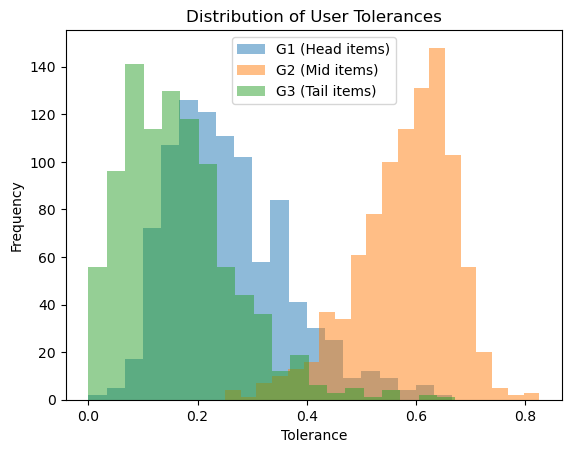

In [19]:
# Create separate lists for each category (e.g., G1, G2, G3)
g1, g2, g3 = tolerance_array.T  # Transpose to split into groups

# Plot histograms for each category
plt.hist(g1, bins=20, alpha=0.5, label="G1 (Head items)")
plt.hist(g2, bins=20, alpha=0.5, label="G2 (Mid items)")
plt.hist(g3, bins=20, alpha=0.5, label="G3 (Tail items)")

plt.title("Distribution of User Tolerances")
plt.xlabel("Tolerance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Running the model

In [ ]:
if __name__ == "__main__":    
    num_weeks = 10
    weekly_results, recommendations_df = evaluate_over_weeks(ratings, num_weeks)

    # Loop over each week and apply CP re-ranking
    all_reranked_recommendations = []
    for week in range(1, num_weeks + 1):
        print(f"Processing week {week}...")
        weekly_recommendations = recommendations_df[recommendations_df['week'] == week]  # Filter recommendations for the week
        
        print(f"Checking weekly recommendations for week {week}:")
        print(weekly_recommendations.head())  # Verify 'week' column exists here

        # Apply CP re-ranking
        logging.info(f"Applying CP re-ranking for week {week}...")
        reranked_recommendations = cali(weekly_recommendations, alpha, k, week)

        # Add to the list of reranked recommendations
        all_reranked_recommendations.append(reranked_recommendations)

    # Combine all reranked recommendations into a single DataFrame
    reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)

    # Check if the 'week' column is preserved in the final DataFrame
    print("Checking final reranked_df:")
    print(reranked_df.head())

    reranked_df.to_csv("weekly_reranked_recommendations.csv", index=False)

    print(pd.DataFrame(weekly_results))

2025-02-13 14:44:54,538 - Processing week 1 (1997-09-20 to 1997-09-27)...
2025-02-13 14:44:54,547 - Starting training for week 1...
2025-02-13 14:44:54,888 - Training complete for week 1.
2025-02-13 14:44:54,999 - Week 1 RMSE: 1.0987
2025-02-13 14:44:55,000 - Generating recommendations for 57 active users in week 1...
Recommending for week 1: 100%|██████████████████| 57/57 [00:20<00:00,  2.85it/s]
2025-02-13 14:45:15,029 - Processing week 2 (1997-09-27 to 1997-10-04)...
2025-02-13 14:45:15,036 - Starting training for week 2...
2025-02-13 14:45:15,176 - Training complete for week 2.
2025-02-13 14:45:15,228 - Week 2 RMSE: 1.1016
2025-02-13 14:45:15,228 - Generating recommendations for 59 active users in week 2...
Recommending for week 2: 100%|██████████████████| 59/59 [00:20<00:00,  2.90it/s]
2025-02-13 14:45:35,609 - Processing week 3 (1997-10-04 to 1997-10-11)...
2025-02-13 14:45:35,624 - Starting training for week 3...
2025-02-13 14:45:35,772 - Training complete for week 3.
2025-02-13

In [ ]:
reranked_df.head(15)

In [ ]:
recommendations_df.head(15)

In [ ]:
for result in weekly_results:
    print(f"Week {result['week']}: RMSE = {result['rmse']:.4f} - Precision@10: {result['precision@10']:.4f}, "
          f"Recall@10: {result['recall@10']:.4f}, Active Users = {result['num_active_users']}, "
          f"Gini Index of Recommendations = {result['gini_index']:.4f}, "
          f"ARP = {result['arp']:.4f}, "
          f"APLT = {result['aplt']:.4f}") 

## Metrics for re-ranking technique

In [ ]:

def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    #recommendation_count = Counter([pred.iid for pred in movie_ids])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    print(recommendation_count, recommendation_array)
    return gini_index #, recommendation_count, recommendation_array


In [ ]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute ARP using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [ ]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [ ]:
item_popularity = reranked_df['movieId'].value_counts(normalize=True).to_dict()

In [ ]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_items = set(G[2])

In [ ]:
results = []
weekly_data = {week: week_data for week, week_data in reranked_df.groupby('week')}
for week, week_data in weekly_data.items():
    movie_ids = week_data['movieId'].tolist()
    
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    weekly_arp = calculate_arp(week_data, item_popularity)
    weekly_aplt = calculate_aplt(week_data, long_tail_items)
    
    results.append({"week": week, "gini_index": gini_index, "arp": weekly_arp, "aplt": weekly_aplt})
    

results_df = pd.DataFrame(results)

print(results_df)

results_df.to_csv("beyond_accuracy_per_week.csv", index=False)


In [ ]:
short_head_items = set(G[0])  # Short head items
mid_items = set(G[1])         # Mid-tier items
long_tail_items = set(G[2])   # Long tail items

# Now you can work with these sets in your further analysis
#long_tail_items_set = set(long_tail_items)

# Check the lengths of each group
print("Short Head Items:", len(short_head_items))
print("Mid Items:", len(mid_items))
print("Long Tail Items:", len(long_tail_items))

In [ ]:
# Initialize a dictionary to store the counts of each group
weekly_group_counts = []

# Iterate through each week and classify the recommendations
for week in reranked_df['week'].unique():
    week_data = reranked_df[reranked_df['week'] == week]
    recommended_items = week_data['movieId'].tolist()  # List of recommended movie IDs for this week
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 1
        elif movie_id in mid_items:
            mid_count += 1
        elif movie_id in long_tail_items:
            long_tail_count += 1

    # Store the counts for this week
    weekly_group_counts.append({
        'week': week,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_df = pd.DataFrame(weekly_group_counts)

# Display the group counts per week
print(group_counts_df)

# Optionally, save to CSV for further analysis
group_counts_df.to_csv('weekly_group_counts.csv', index=False)


In [ ]:
# Initialize a dictionary to store the counts of each group
weekly_group_counts = []

# Iterate through each week and classify the recommendations
for week in recommendations_df['week'].unique():
    week_data = recommendations_df[recommendations_df['week'] == week]
    recommended_items = week_data['movieId'].tolist()  # List of recommended movie IDs for this week
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 0.1
        elif movie_id in mid_items:
            mid_count += 0.1
        elif movie_id in long_tail_items:
            long_tail_count += 0.1

    # Store the counts for this week
    weekly_group_counts.append({
        'week': week,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_svd_df = pd.DataFrame(weekly_group_counts)

# Display the group counts per week
print(group_counts_svd_df)

# Optionally, save to CSV for further analysis
group_counts_svd_df.to_csv('weekly_group_counts_svd.csv', index=False)

## Main model and CP re-ranking graphs

In [ ]:
weeks = [result['week'] for result in weekly_results]

rmse_values = [result['rmse'] for result in weekly_results]

precision_values = [result['precision@10'] for result in weekly_results]

recall_values = [result['recall@10'] for result in weekly_results]

gini_values = [result['gini_index'] for result in weekly_results]

user_values = [result['num_active_users'] for result in weekly_results]

arp = [result['arp'] for result in weekly_results]

aplt = [result['aplt'] for result in weekly_results]

In [ ]:
#Gini
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, gini_values, marker='o', color='b', label='Gini index')
plt.plot(results_df['week'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')
plt.title('Gini index Over Time ↓')
plt.xlabel('Week')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, arp, marker='o', color='b', label='ARP')
plt.plot(results_df['week'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time ↓')
plt.xlabel('Week')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, aplt, marker='o', color='b', label='APLT')
plt.plot(results_df['week'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('APLT Over Time ↑')
plt.xlabel('Week')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('Week')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()


#RMSE, Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(weeks, rmse_values, marker='o', color='b', label='RMSE')
plt.plot(weeks, precision_values, marker='o', color='g', label='Precision@10')
plt.plot(weeks, recall_values, marker='o', color='r', label='Recall@10')

plt.title('RMSE, Precision, Recall and Gini Index Over Time')
plt.xlabel('Week')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract data for plotting
weeks = group_counts_df['week']
short_head_counts = group_counts_df['short_head_count']
mid_counts = group_counts_df['mid_count']
long_tail_counts = group_counts_df['long_tail_count']

# Plot the counts for each group
plt.figure(figsize=(7.5, 4.5))

# Plot each group with a different color
plt.plot(weeks, short_head_counts, marker='o', color='b', label='Short-head items')
plt.plot(weeks, mid_counts, marker='o', color='g', label='Mid-tier items')
plt.plot(weeks, long_tail_counts, marker='o', color='r', label='Long-tail items')

# Add labels and title
plt.title('Distribution of Recommended Items Over Time Re-ranked')
plt.xlabel('Week')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Extract data for plotting
weeks2 = group_counts_svd_df['week']
short_head_counts2 = group_counts_svd_df['short_head_count']
mid_counts2 = group_counts_svd_df['mid_count']
long_tail_counts2 = group_counts_svd_df['long_tail_count']

# Plot the counts for each group
plt.figure(figsize=(7.5, 4.5))

# Plot each group with a different color
plt.plot(weeks2, short_head_counts2, marker='o', color='b', label='Short-head items')
plt.plot(weeks2, mid_counts2, marker='o', color='g', label='Mid-tier items')
plt.plot(weeks2, long_tail_counts2, marker='o', color='r', label='Long-tail items')

# Add labels and title
plt.title('Distribution of Recommended Items Over Time SVD')
plt.xlabel('Week')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()